In [30]:
import os
os.environ["DEVELOPMENT"] = "DEVELOPMENT"

In [31]:
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
results_dir = Path("results/seedtest")
config = json.load(open(results_dir / "config.json"))
gens = config["evolution_params"]["n_generations"]

In [33]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]

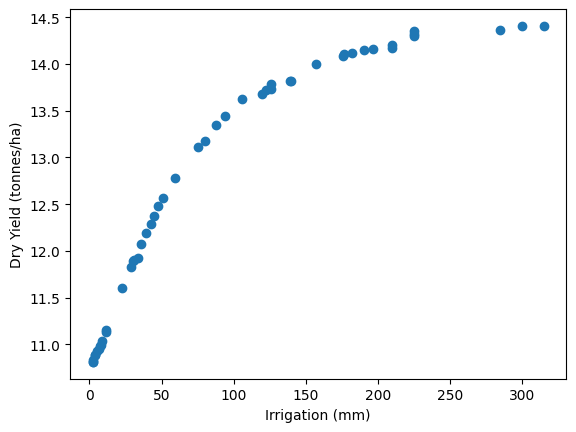

In [34]:
plt.scatter(-1 * final_pareto["irrigation"], final_pareto["yield"])
plt.xlabel("Irrigation (mm)")
plt.ylabel("Dry Yield (tonnes/ha)")
plt.show()

In [35]:
import numpy as np
from evolution.evaluation.evaluator import Evaluator
import warnings
from scipy.optimize import fmin

In [36]:
def evaluate(x, max_irr_season, evaluator):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results = evaluator.run_model(x, max_irr_season, 2018, 2018)
    reward = -1 * results["Dry yield (tonne/ha)"].mean()
    return reward

In [37]:
def get_starting_point(num_smts, max_irr_season, num_searches, evaluator):
    """
    find good starting threshold(s) for optimization
    """

    # get random SMT's
    x0list = np.random.rand(num_searches,num_smts)*100
    rlist=[]
    # evaluate random SMT's
    for xtest in x0list:
        reward = evaluate(xtest, max_irr_season, evaluator)
        rlist.append(reward)

    # save best SMT
    x0=x0list[np.argmin(rlist)]
    
    return x0

evaluator = Evaluator()
get_starting_point(4, 100, 10, evaluator)

/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/utils/prepare_weather.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  weather_df = pd.read_csv(weather_file_path, header=0, delim_whitespace=True)
/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/utils/prepare_weather.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df.ReferenceET.clip(lower=0.1, inplace=True

array([26.36964209, 33.95306633, 59.27559979, 56.51051237])

In [38]:
def optimize(num_smts, max_irr_season, evaluator, num_searches=100):
    """ 
    optimize thresholds to be profit maximising
    """
    # get starting optimization strategy
    x0=get_starting_point(num_smts, max_irr_season, num_searches, evaluator)
    # run optimization 
    res = fmin(evaluate, x0, disp=0, args=(max_irr_season, evaluator))
    # reshape array
    smts= res.squeeze()
    # evaluate optimal strategy
    return smts

In [41]:
yields = []
irrs = []
points = 100
for i in tqdm(range(points+1)):
    max_irr_season = i * (450/points)
    smts = optimize(4, max_irr_season, evaluator, 10)
    results = evaluator.run_model(smts, max_irr_season, 2018, 2018)
    dry_yield = results["Dry yield (tonne/ha)"].mean()
    irr = results["Seasonal irrigation (mm)"].mean()
    yields.append(dry_yield)
    irrs.append(irr)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/entities/co2.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.co2_data = pd.read_csv(
/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/entities/soil.py:363: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.profile = self.profile.fillna(method="ffill")
 10%|█         | 1/10 [00:08<01:13,  8.18s/it]/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/entities/co2.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.co2_data = pd.read_csv(
/Users/danyoung/workspace/aquacrop/.venv/lib/python3.9/site-packages/aquacrop/entitie

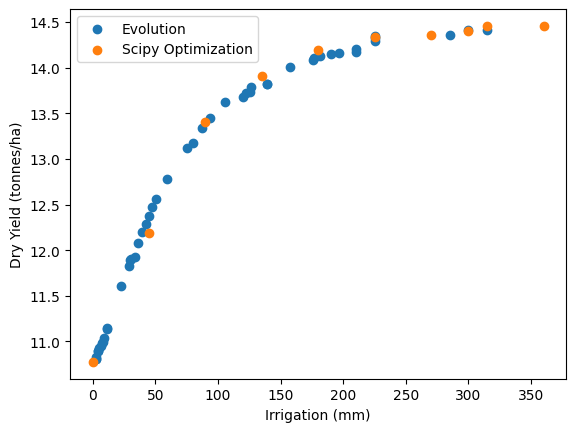

In [43]:
plt.scatter(-1 * final_pareto["irrigation"], final_pareto["yield"], label="Evolution")
plt.scatter(irrs, yields, label="Scipy Optimization")
plt.legend()
plt.xlabel("Irrigation (mm)")
plt.ylabel("Dry Yield (tonnes/ha)")
plt.show()